In [1]:
import os 
import sys
import pandas as pd
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.signal import correlate
from scipy.spatial.distance import pdist
from sklearn.metrics.pairwise import cosine_similarity




In [2]:
os.chdir("/home/vijay/paper_jc/raw_dataset/across_setting")
filenames = glob.glob('*.csv')
print(filenames)
names= os.listdir('/home/vijay/paper_jc/raw_dataset/across_setting')
def create_dataframe(name):
  df = pd.DataFrame()  # Empty DataFrame
  for filename in glob.glob("*.csv"):  # Assuming all CSV files are in the current directory
    if filename.startswith(f"{name}"):
      df_temp = pd.read_csv(filename, index_col=[0])
      df = pd.concat([df, df_temp], ignore_index=True)
      df = df.drop(df.columns[-1:], axis=1)  # Drop last 2 columns
      df = df.dropna()  # Remove rows with NaN
  return df

dataframes = {}  # Dictionary to store DataFrames
for name in names:
  dataframes[name] = create_dataframe(name)


for name, df in dataframes.items():
  print(f"DataFrame for '{name}':{df.columns.size} columns")

['set1.csv', 'set2.csv']
DataFrame for 'set1.csv':114 columns
DataFrame for 'set2.csv':114 columns


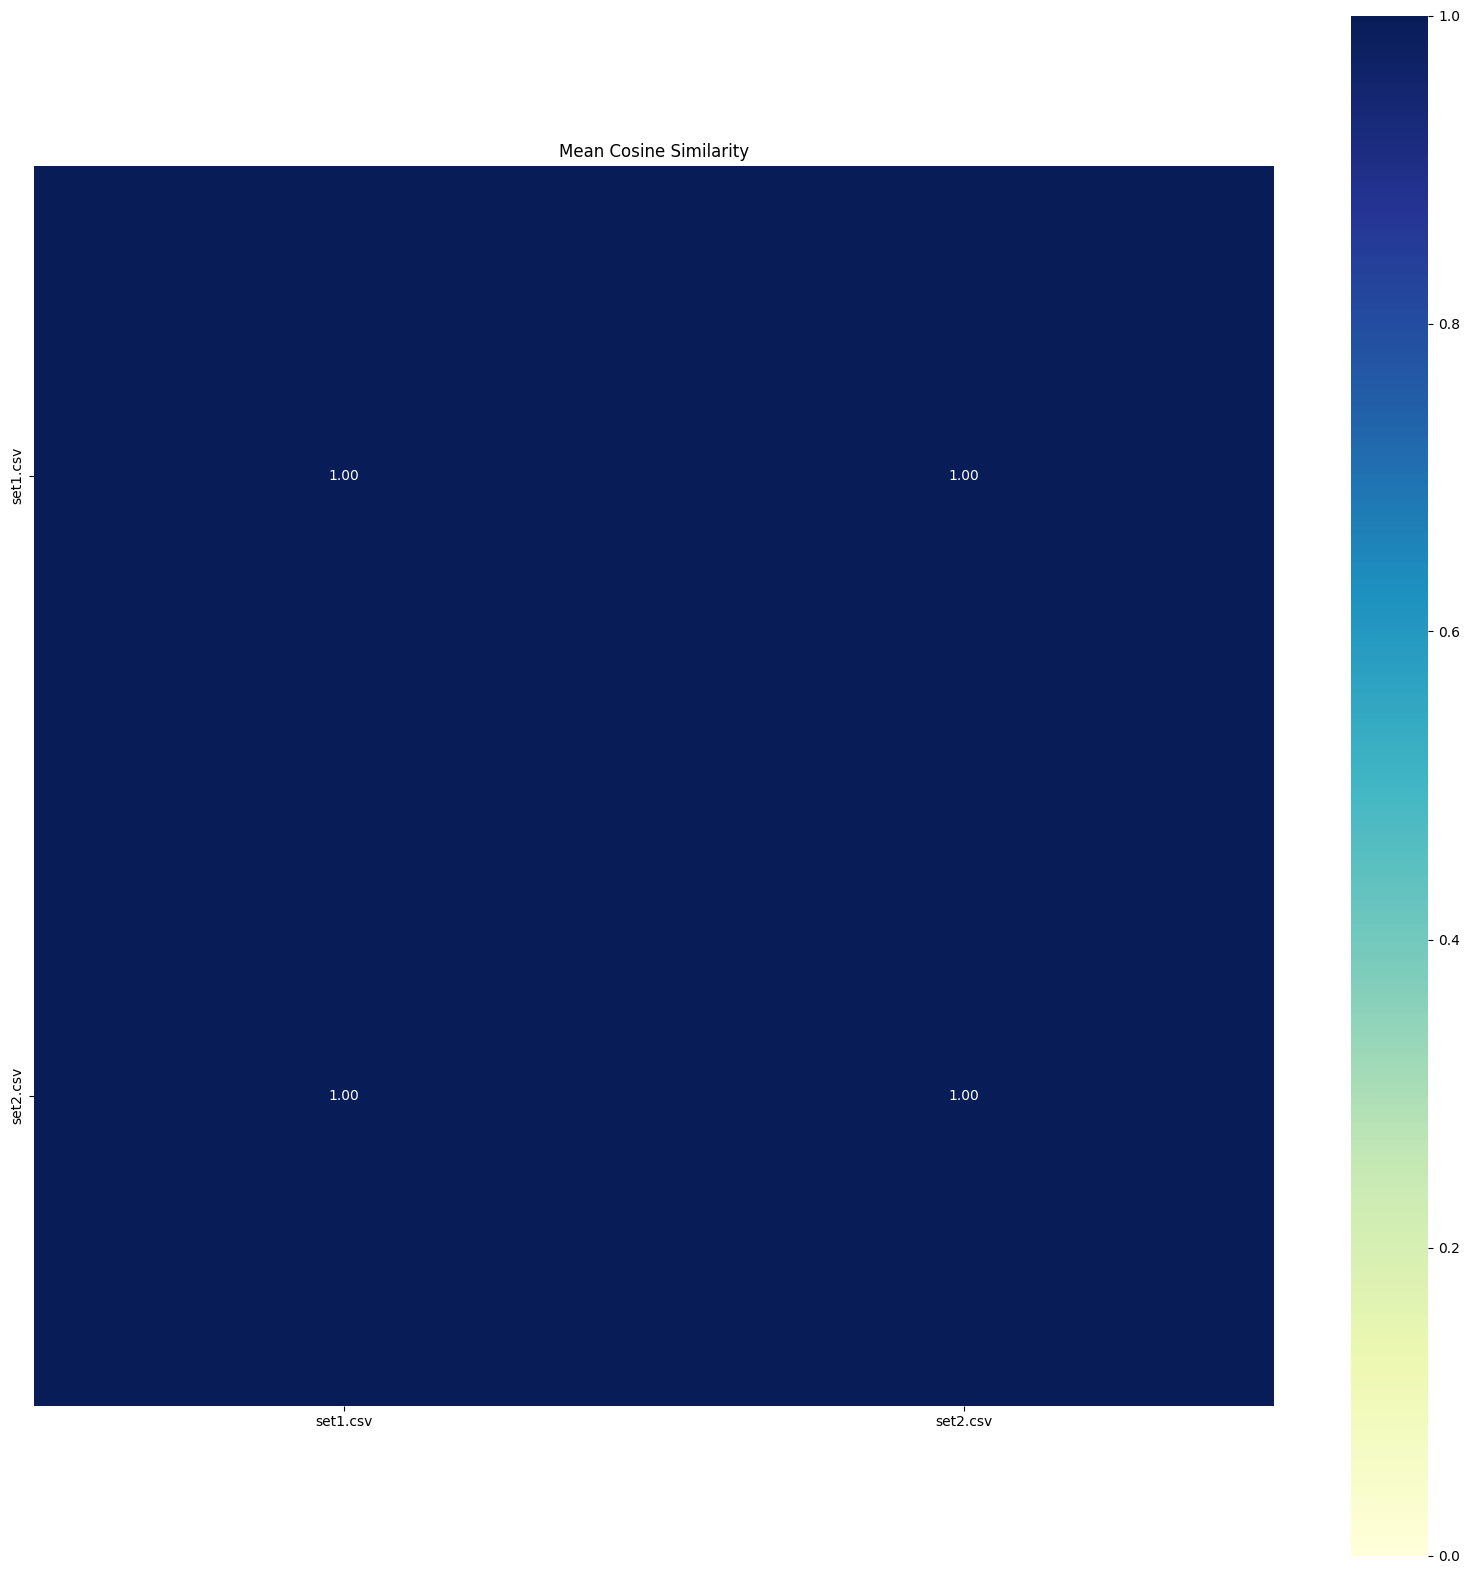

In [3]:
mean_cos_sim_values = {}
for i in range(len(dataframes)):
  for j in range(i, len(dataframes)):
    # Select DataFrames from the dictionary
    df_i = dataframes[names[i]].iloc[:] 
    df_j = dataframes[names[j]].iloc[:]

    # Handle missing values (optional)
    # ... (code for handling missing values, if necessary)

    # Ensure numerical data for cosine similarity
    df_i_num = df_i.select_dtypes(include=[np.number])
    df_j_num = df_j.select_dtypes(include=[np.number])

    # Calculate cosine similarity for each column pair (batch processing)
    cos_sim_values = []
    for col_i in df_i_num.columns:
      if col_i in df_j_num.columns:  # Check if column exists in both DataFrames
        cos_sim = cosine_similarity(df_i_num[col_i].values.reshape(-1, 1), df_j_num[col_i].values.reshape(-1, 1))[0][0]
        cos_sim_values.append(cos_sim)

    # Calculate mean cosine similarity (average across all column pairs)
    if len(cos_sim_values) > 0:  # Avoid division by zero if no columns match
      mean_cos_sim = np.mean(cos_sim_values)
      mean_cos_sim_values[(i, j)] = mean_cos_sim
      mean_cos_sim_values[(j, i)] = mean_cos_sim

# Convert the dictionary to a 2D array
mean_cos_sim_array = np.zeros((len(dataframes), len(dataframes)))
for key, value in mean_cos_sim_values.items():
    mean_cos_sim_array[key] = value

# Define labels from the names list
labels = names

plt.figure(figsize=(20, 20))  # Increase figure size

sns.heatmap(mean_cos_sim_array, cmap='YlGnBu', cbar=True, square=True,
            xticklabels=labels, yticklabels=labels, vmin=0, vmax=1,  # Adjust vmin and vmax for cosine similarity
            annot=True, fmt=".2f")  # Display rounded values with fmt=".2f"

plt.title('Mean Cosine Similarity')
plt.show()

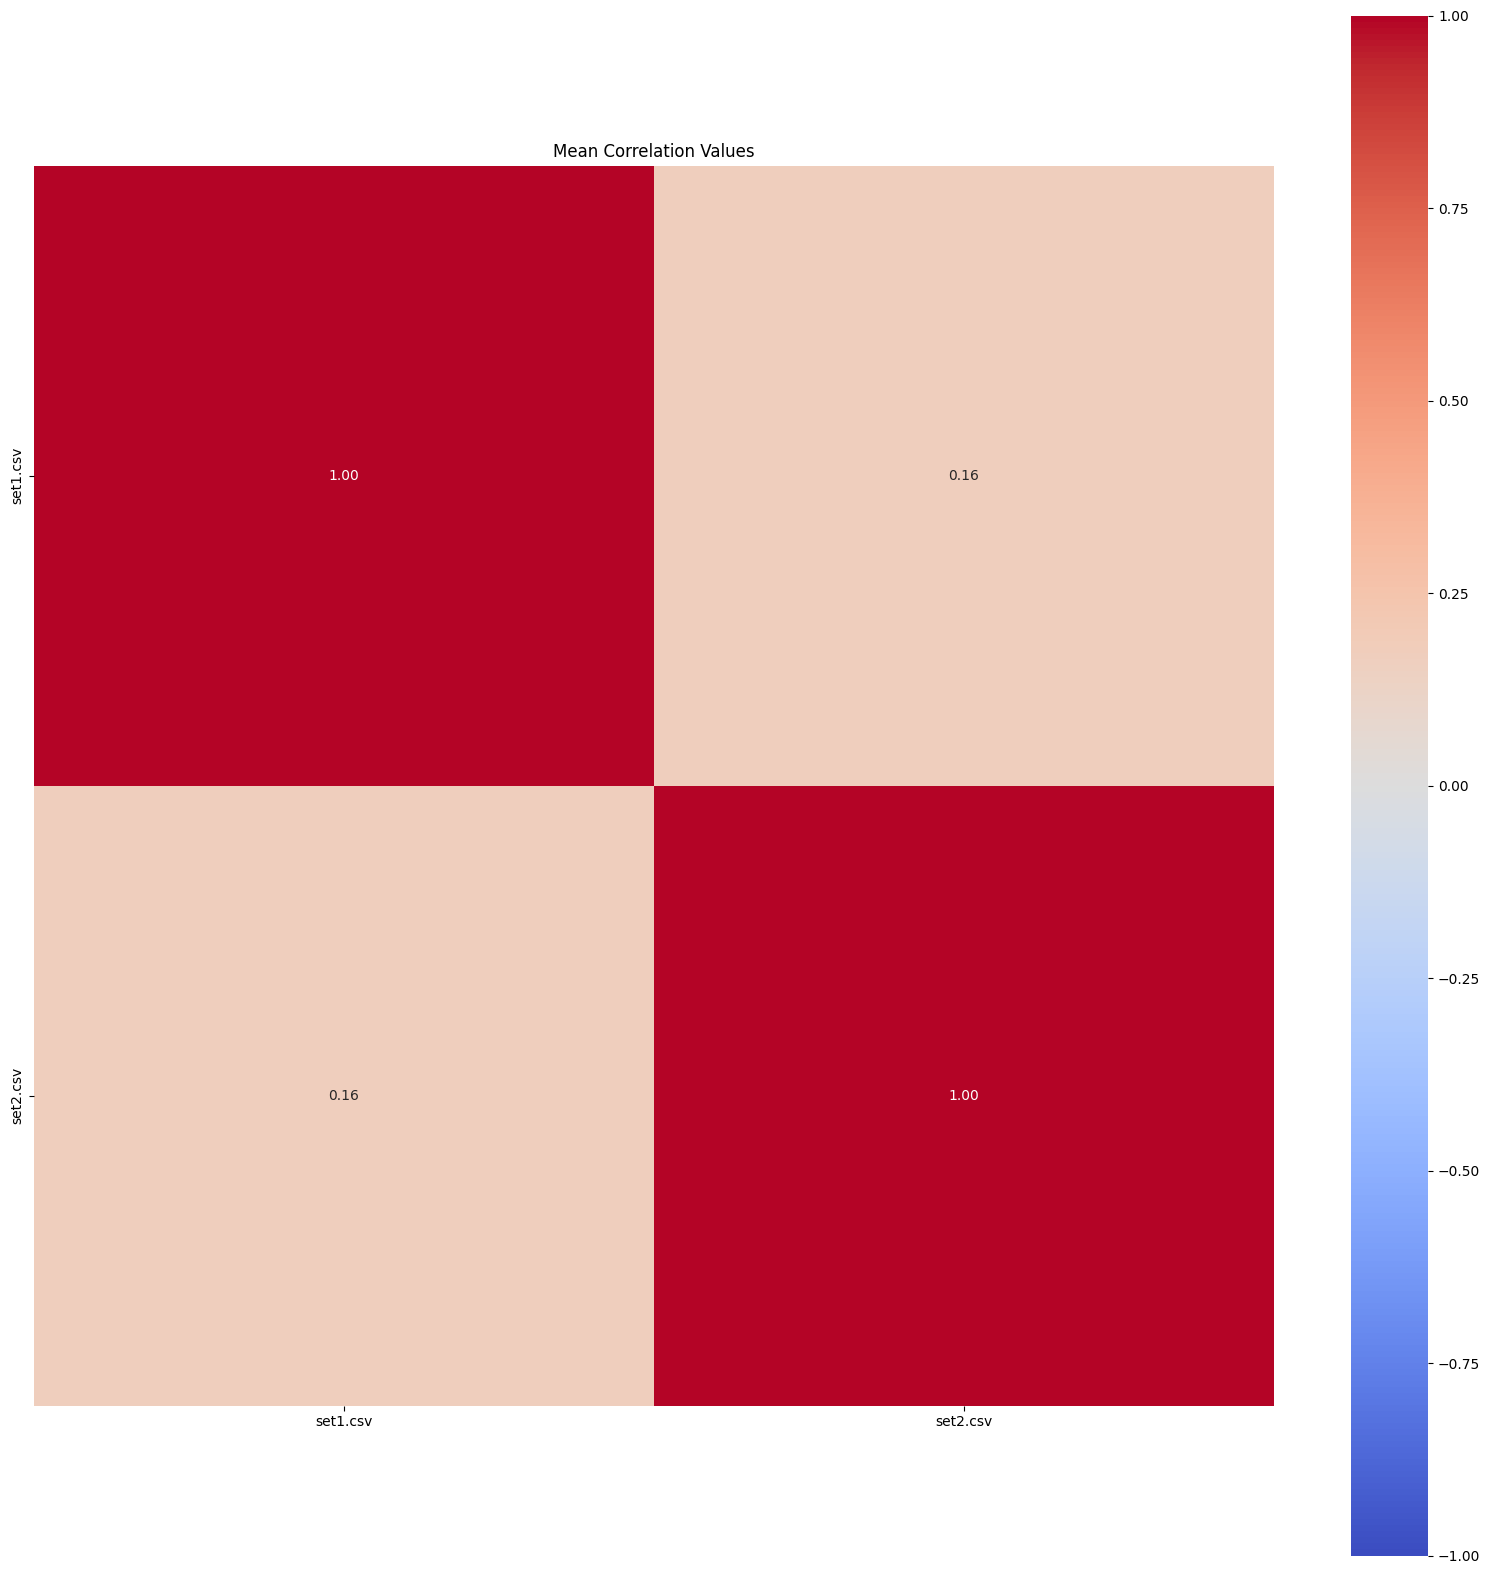

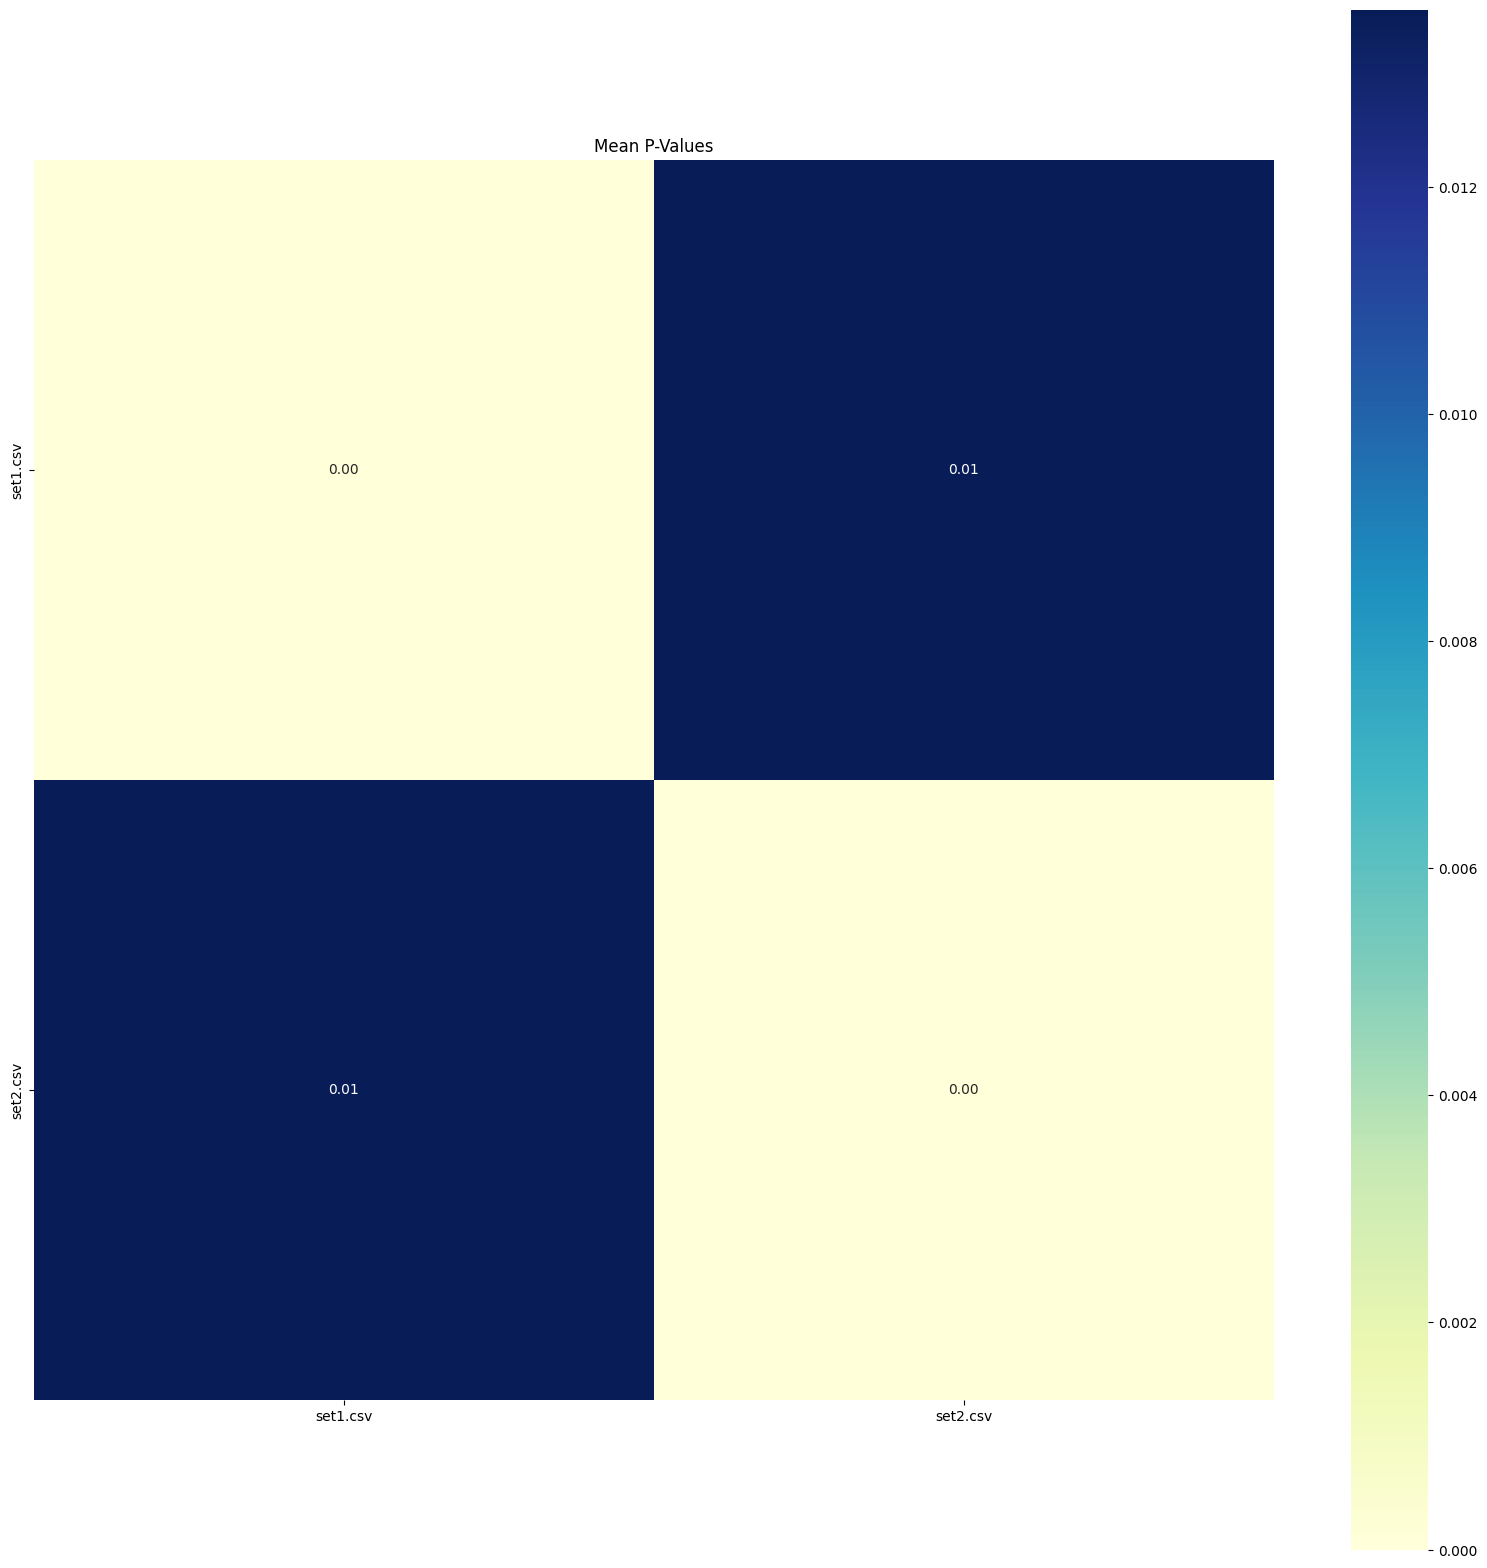

In [4]:
mean_corr_values = {}
mean_p_values = {}

# Iterate over each pair of datasets
for i in range(len(dataframes)):
    for j in range(i, len(dataframes)):
        # Select DataFrames from the dictionary
        df_i = dataframes[names[i]]
        df_j = dataframes[names[j]]

        # Initialize lists to store the correlation and p-value for each pair of columns
        corr_values = []
        p_values = []

        # Iterate over each pair of columns (up to the minimum number of columns)
        for k in range(min(df_i.shape[1], df_j.shape[1])):
            # Check for missing values and zero variance (adjust column selection if needed)
            min_length = min(len(df_i.iloc[:, k]), len(df_j.iloc[:, k]))
            if df_i.iloc[:min_length, k].isnull().sum() > 0 or df_j.iloc[:min_length, k].isnull().sum() > 0 or df_i.iloc[:min_length, k].var() == 0 or df_j.iloc[:min_length, k].var() == 0:
                continue

            # Calculate the correlation and p-value
            corr, p = pearsonr(df_i.iloc[:min_length, k], df_j.iloc[:min_length, k])

            # Append the values to the lists
            corr_values.append(corr)
            p_values.append(p)

        # Calculate the mean correlation and p-value and store them in the dictionaries
        mean_corr_values[(i, j)] = np.mean(corr_values)
        mean_p_values[(i, j)] = np.mean(p_values)
        # Add values for the other order (symmetric matrix)
        mean_corr_values[(j, i)] = np.mean(corr_values)
        mean_p_values[(j, i)] = np.mean(p_values)

# Convert the dictionaries to 2D arrays
mean_corr_values_array = np.zeros((len(dataframes), len(dataframes)))
mean_p_values_array = np.zeros((len(dataframes), len(dataframes)))
for key, value in mean_corr_values.items():
    mean_corr_values_array[key] = value
for key, value in mean_p_values.items():
    mean_p_values_array[key] = value

# Define labels from the names list
labels = names

plt.figure(figsize=(20, 20))  # Increase figure size

sns.heatmap(mean_corr_values_array, cmap='coolwarm', cbar=True, square=True,
            xticklabels=labels, yticklabels=labels, vmin=-1, vmax=1,  # Adjust vmin and vmax for correlation values
            annot=True, fmt=".2f")  # Display rounded values with fmt=".2f"

plt.title('Mean Correlation Values')
plt.show()

plt.figure(figsize=(20, 20))  # Increase figure size

sns.heatmap(mean_p_values_array, cmap='YlGnBu', cbar=True, square=True,
            xticklabels=labels, yticklabels=labels, annot=True, fmt=".2f")  # Display rounded values with fmt=".2f"
plt.title('Mean P-Values')
plt.show()


In [25]:
os.chdir("/home/vijay/paper_jc/raw_dataset/raw_phase2")
filenames = glob.glob('*.csv')
print(filenames)
names = ["wall", "tx", "two", "rx", "obs", "distance", "diff"]
def create_dataframe(name):
  df = pd.DataFrame()  # Empty DataFrame
  for filename in glob.glob("*.csv"):  # Assuming all CSV files are in the current directory
    if filename.startswith(f"{name}_"):
      df_temp = pd.read_csv(filename)
      df = pd.concat([df, df_temp], ignore_index=True)
      df = df.drop(df.columns[-2:], axis=1)  # Drop last 2 columns
      df = df.dropna()  # Remove rows with NaN
  return df

dataframes = {}  # Dictionary to store DataFrames
for name in names:
  dataframes[name] = create_dataframe(name)


for name, df in dataframes.items():
  print(f"DataFrame for '{name}':{df.columns.size} columns")

['distance_2.csv', 'two_Participant_Aayush_Arnav.csv', 'two_participants.csv', 'rx_angle_experiment_6.csv', 'tx_angle_experiment_4.csv', 'tx_angle_experiment_6.csv', 'obs_glass_5_metre.csv', 'wall_mounted_3.csv', 'rx_angle_experiment_5.csv', 'obs_wood_2_meter.csv', 'diff_tx_disc_room_rx_lab.csv', 'distance_3.csv', 'rx_angle_experiment_3.csv', 'distance_1_5.csv', 'wall_mounted_5.csv', 'wall_mounted_2.csv', 'distance_1.csv', 'tx_angle_experiment_2.csv', 'obs_wooden_panel.csv', 'diff_tx_meet.csv', 'tx_angle_experiment_5.csv', 'two_Participant_Arnav_Aayush.csv', 'distance_4.csv', 'rx_angle_experiment_1.csv', 'tx_angle_experiment_1.csv', 'rx_angle_experiment_2.csv', 'rx_angle_experiment_4.csv', 'two_Participant_Anubhav_Arnav.csv', 'obs_nylon_2_5_meter.csv', 'wall_mounted_4.csv', 'diff_tx_lab_rx_disc_room.csv', 'wall_mounted_1.csv', 'tx_angle_experiment_3.csv', 'distance_2_5.csv', 'distance_5.csv']
DataFrame for 'wall':385 columns
DataFrame for 'tx':385 columns
DataFrame for 'two':385 column

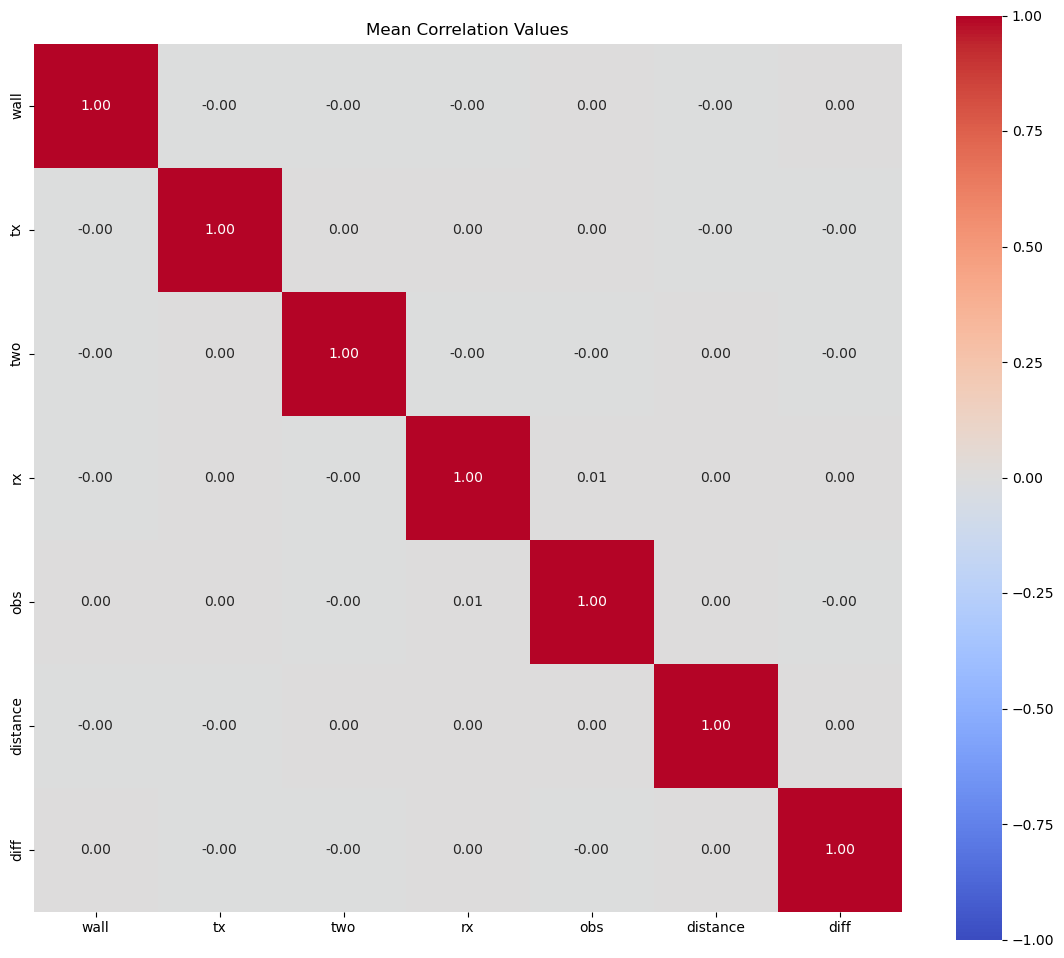

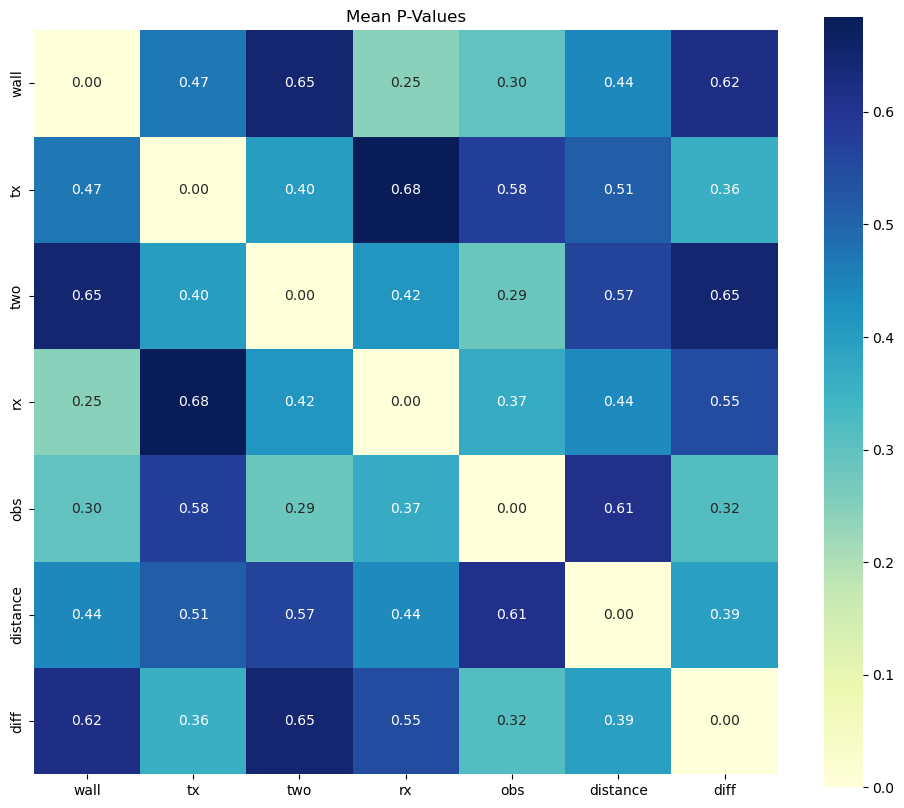

In [39]:
mean_corr_values = {}
mean_p_values = {}

# Iterate over each pair of datasets
for i in range(len(dataframes)):
    for j in range(i, len(dataframes)):
        # Select DataFrames from the dictionary
        df_i = dataframes[names[i]]
        df_j = dataframes[names[j]]

        # Initialize lists to store the correlation and p-value for each pair of columns
        corr_values = []
        p_values = []

        # Iterate over each pair of columns (up to the minimum number of columns)
        for k in range(min(df_i.shape[1], df_j.shape[1])):
            # Check for missing values and zero variance (adjust column selection if needed)
            min_length = min(len(df_i.iloc[:, k]), len(df_j.iloc[:, k]))
            if df_i.iloc[:min_length, k].isnull().sum() > 0 or df_j.iloc[:min_length, k].isnull().sum() > 0 or df_i.iloc[:min_length, k].var() == 0 or df_j.iloc[:min_length, k].var() == 0:
                continue

            # Calculate the correlation and p-value
            corr, p = pearsonr(df_i.iloc[:min_length, k], df_j.iloc[:min_length, k])

            # Append the values to the lists
            corr_values.append(corr)
            p_values.append(p)

        # Calculate the mean correlation and p-value and store them in the dictionaries
        mean_corr_values[(i, j)] = np.mean(corr_values)
        mean_p_values[(i, j)] = np.mean(p_values)
        # Add values for the other order (symmetric matrix)
        mean_corr_values[(j, i)] = np.mean(corr_values)
        mean_p_values[(j, i)] = np.mean(p_values)

# Convert the dictionaries to 2D arrays
mean_corr_values_array = np.zeros((len(dataframes), len(dataframes)))
mean_p_values_array = np.zeros((len(dataframes), len(dataframes)))
for key, value in mean_corr_values.items():
    mean_corr_values_array[key] = value
for key, value in mean_p_values.items():
    mean_p_values_array[key] = value

# Define labels from the names list
labels = names

plt.figure(figsize=(14, 12))  # Increase figure size

sns.heatmap(mean_corr_values_array, cmap='coolwarm', cbar=True, square=True,
            xticklabels=labels, yticklabels=labels, vmin=-1, vmax=1,  # Adjust vmin and vmax for correlation values
            annot=True, fmt=".2f")  # Display rounded values with fmt=".2f"

plt.title('Mean Correlation Values')
plt.show()

plt.figure(figsize=(12, 10))  # Increase figure size

sns.heatmap(mean_p_values_array, cmap='YlGnBu', cbar=True, square=True,
            xticklabels=labels, yticklabels=labels, annot=True, fmt=".2f")  # Display rounded values with fmt=".2f"
plt.title('Mean P-Values')
plt.show()


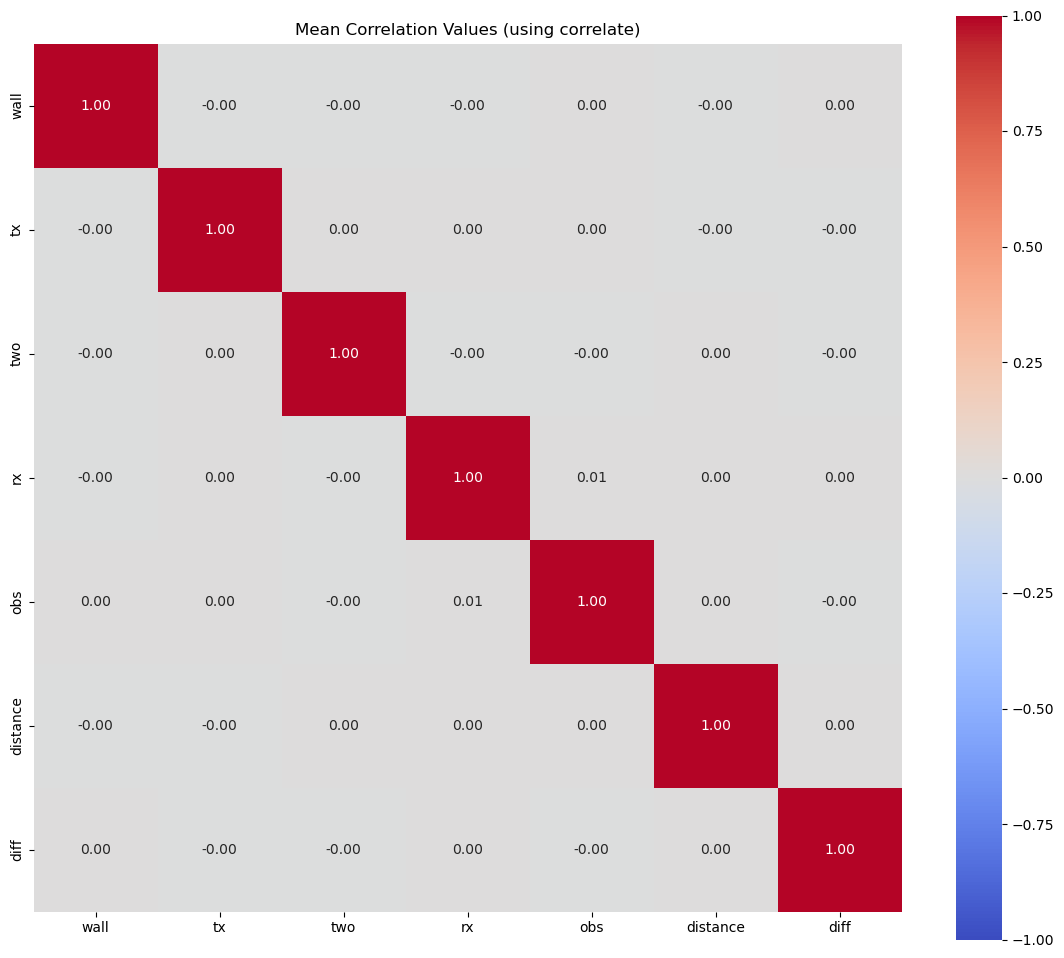

In [52]:
mean_corr_values = {}
mean_p_values = {}

# Iterate over each pair of datasets
for i in range(len(dataframes)):
    for j in range(i, len(dataframes)):
        # Select DataFrames from the dictionary
        df_i = dataframes[names[i]]
        df_j = dataframes[names[j]]

        # Initialize lists to store the correlation and p-value for each pair of columns
        corr_values = []
        p_values = []

        # Iterate over each pair of columns (up to the minimum number of columns)
        for k in range(min(df_i.shape[1], df_j.shape[1])):
            # Check for missing values and zero variance (adjust column selection if needed)
            min_length = min(len(df_i.iloc[:, k]), len(df_j.iloc[:, k]))
            if df_i.iloc[:min_length, k].isnull().sum() > 0 or df_j.iloc[:min_length, k].isnull().sum() > 0 or df_i.iloc[:min_length, k].var() == 0 or df_j.iloc[:min_length, k].var() == 0:
                continue

            # Calculate the correlation and p-value
            corr, p = pearsonr(df_i.iloc[:min_length, k], df_j.iloc[:min_length, k])
            temp_check_var=correlate(2,3)

            # Append the values to the lists
            corr_values.append(corr)
            p_values.append(p)

        # Calculate the mean correlation and p-value and store them in the dictionaries
        mean_corr_values[(i, j)] = np.mean(corr_values)
        mean_p_values[(i, j)] = np.mean(p_values)
        # Add values for the other order (symmetric matrix)
        mean_corr_values[(j, i)] = np.mean(corr_values)
        mean_p_values[(j, i)] = np.mean(p_values)

# Convert the dictionaries to 2D arrays
mean_corr_values_array = np.zeros((len(dataframes), len(dataframes)))
mean_p_values_array = np.zeros((len(dataframes), len(dataframes)))
for key, value in mean_corr_values.items():
    mean_corr_values_array[key] = value
for key, value in mean_p_values.items():
    mean_p_values_array[key] = value

# Define labels from the names list
labels = names

plt.figure(figsize=(14, 12))  # Increase figure size

sns.heatmap(mean_corr_values_array, cmap='coolwarm', cbar=True, square=True,
            xticklabels=labels, yticklabels=labels, vmin=-1, vmax=1,  # Adjust vmin and vmax for correlation values
            annot=True, fmt=".2f")  # Display rounded values with fmt=".2f"

plt.title('Mean Correlation Values (using correlate)')
plt.show()



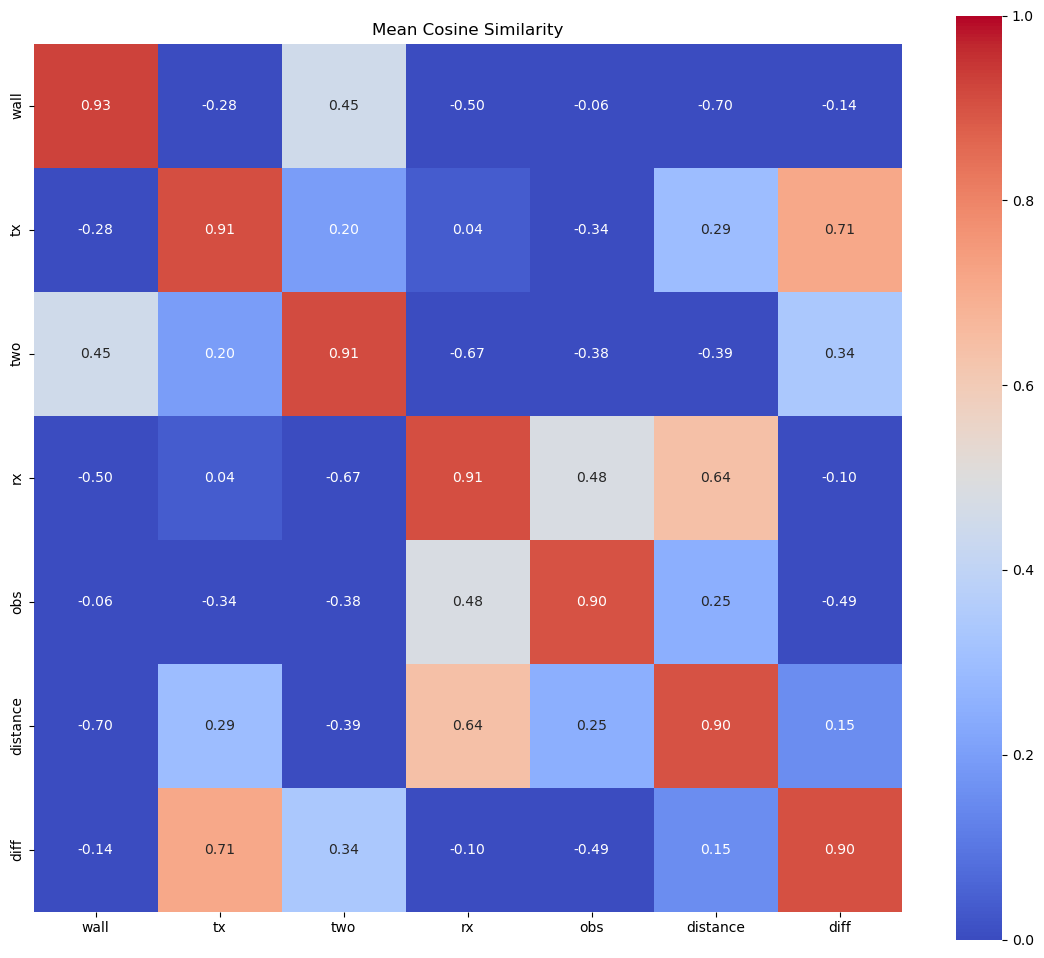

In [30]:
mean_cos_sim_values = {}
for i in range(len(dataframes)):
  for j in range(i, len(dataframes)):
    # Select DataFrames from the dictionary
    df_i = dataframes[names[i]].iloc[:4000] 
    df_j = dataframes[names[j]].iloc[:4000]

    # Handle missing values (optional)
    # ... (code for handling missing values, if necessary)

    # Ensure numerical data for cosine similarity
    df_i_num = df_i.select_dtypes(include=[np.number])
    df_j_num = df_j.select_dtypes(include=[np.number])

    # Calculate cosine similarity for each column pair (batch processing)
    cos_sim_values = []
    for col_i in df_i_num.columns:
      if col_i in df_j_num.columns:  # Check if column exists in both DataFrames
        cos_sim = cosine_similarity(df_i_num[col_i].values.reshape(-1, 1), df_j_num[col_i].values.reshape(-1, 1))[0][0]
        cos_sim_values.append(cos_sim)

    # Calculate mean cosine similarity (average across all column pairs)
    if len(cos_sim_values) > 0:  # Avoid division by zero if no columns match
      mean_cos_sim = np.mean(cos_sim_values)
      mean_cos_sim_values[(i, j)] = mean_cos_sim
      mean_cos_sim_values[(j, i)] = mean_cos_sim

# Convert the dictionary to a 2D array
mean_cos_sim_array = np.zeros((len(dataframes), len(dataframes)))
for key, value in mean_cos_sim_values.items():
    mean_cos_sim_array[key] = value

# Define labels from the names list
labels = names

plt.figure(figsize=(14, 12))  # Increase figure size

sns.heatmap(mean_cos_sim_array, cmap='coolwarm', cbar=True, square=True,
            xticklabels=labels, yticklabels=labels, vmin=0, vmax=1,  # Adjust vmin and vmax for cosine similarity
            annot=True, fmt=".2f")  # Display rounded values with fmt=".2f"

plt.title('Mean Cosine Similarity')
plt.show()